tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.9000, 1.0000, 0.2000, 0.0000, 0.0000]])

Input Coordinate: (y x t), (0, 0, 4)
Transforms to: (y t x), (0, 4, 0)


Input Coordinate: (y x t), (0, 1, 4)
Transforms to: (y t x), (0, 4, 1)


Input Coordinate: (y x t), (1, 0, 8)
Transforms to: (y t x), (1, 8, 0)


Input Coordinate: (y x t), (1, 1, 9)
Transforms to: (y t x), (1, 9, 1)


Input Coordinate: (y x t), (1, 2, 1)
Transforms to: (y t x), (1, 1, 2)

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 1.]])





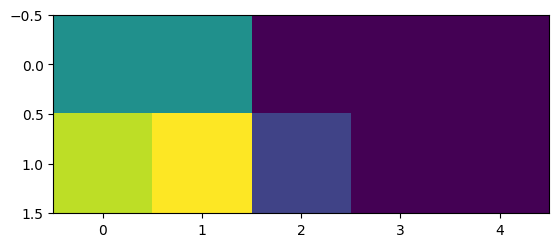

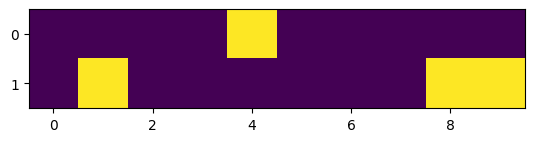

In [1]:
import torch
###

# During processing we want the largest dimesnion to be the one that is virtual, wheras for loss calculation which is important yet trivial on compute we want the largest possible dimensional surface over which to calulate the loss. the smaller of the two dimensions is the one that should be made virtual

def holographic_transform(input_tensor, timesteps, binary_values=True):
    if not isinstance(input_tensor, torch.Tensor):
        raise ValueError("Input tensor should be a torch.Tensor")
    
    if len(input_tensor.shape) != 2:
        raise ValueError("Input tensor should be 2-dimensional")
    
    if timesteps <= 0:
        raise ValueError("Timesteps should be a positive integer")
    
    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    
    for i in range(input_tensor.shape[0]):
        non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
        for j in non_zero_indices:
            value = input_tensor[i,j]
            quantized_value = int(value * timesteps) - 1 
            print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
            print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

            if binary_values:
                output_tensor[i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
            else:  # BROKEN!!!!
                if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                    output_tensor[i, quantized_value] = j.item()


    return output_tensor

# Example usage
input_tensor = torch.tensor([[0.5, 0.5, 0.0, 0.0, 0.0],
                            [0.9, 1.0, 0.2, 0.0, 0.0]])
timesteps = 10
binary_hologram = True


print(input_tensor)
output_tensor = holographic_transform(input_tensor, timesteps, binary_hologram)
print(output_tensor)

print("\n\n")

import matplotlib.pyplot as plt
plt.imshow(input_tensor)
plt.show()

plt.imshow(output_tensor)
plt.show()





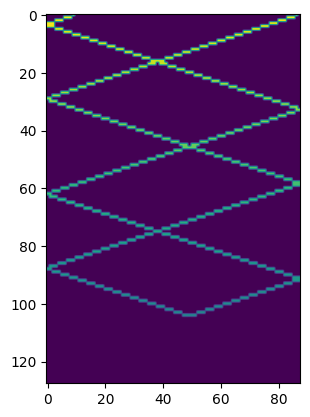

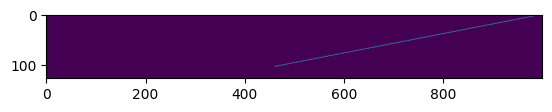

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# During processing we want the largest dimesnion to be the one that is virtual, wheras for loss calculation which is important yet trivial on compute we want the largest possible dimensional surface over which to calulate the loss. the smaller of the two dimensions is the one that should be made virtual

def holographic_transform(input_tensor, timesteps, binary_values=True, debug=False):
    if not isinstance(input_tensor, torch.Tensor):
        raise ValueError("Input tensor should be a torch.Tensor")
    
    if len(input_tensor.shape) != 2:
        raise ValueError("Input tensor should be 2-dimensional")
    
    if timesteps <= 0:
        raise ValueError("Timesteps should be a positive integer")
    
    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    
    for i in range(input_tensor.shape[0]):
        non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
        for j in non_zero_indices:
            value = input_tensor[i,j]
            quantized_value = int(value * timesteps) - 1 

            if debug:
                print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
                print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

            if binary_values:
                output_tensor[i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
            else:  # BROKEN!!!!
                if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                    output_tensor[i, quantized_value] = j.item()


    return output_tensor

# Example usage
timesteps = 1000
binary_hologram = True
input_file_path = r"N:\Yr 3 Project Datasets\PERF VALIDATION SETS\10K 100N 30S\Labels\126.npy .npy"

input_tensor = torch.from_numpy(np.load(input_file_path))
input_tensor = input_tensor / torch.max(input_tensor)
output_tensor = holographic_transform(input_tensor, timesteps, binary_hologram)    #(input_tensor.T, timesteps, binary_hologram)

plt.imshow(input_tensor)
plt.show()

plt.imshow(output_tensor)
plt.show()





In [3]:
def reconstruct_3D(data):
    data_output = []
    for cdx, row in enumerate(data):
        for idx, num in enumerate(row):
            if num > 0:  
                data_output.append([cdx,idx,num])
    return np.array(data_output)

In [4]:
def renormalise_time(tensor, timesteps):
    tensor = tensor * timesteps
    return tensor

(128, 88)
(128, 1000)
(616, 3)
(312, 3)


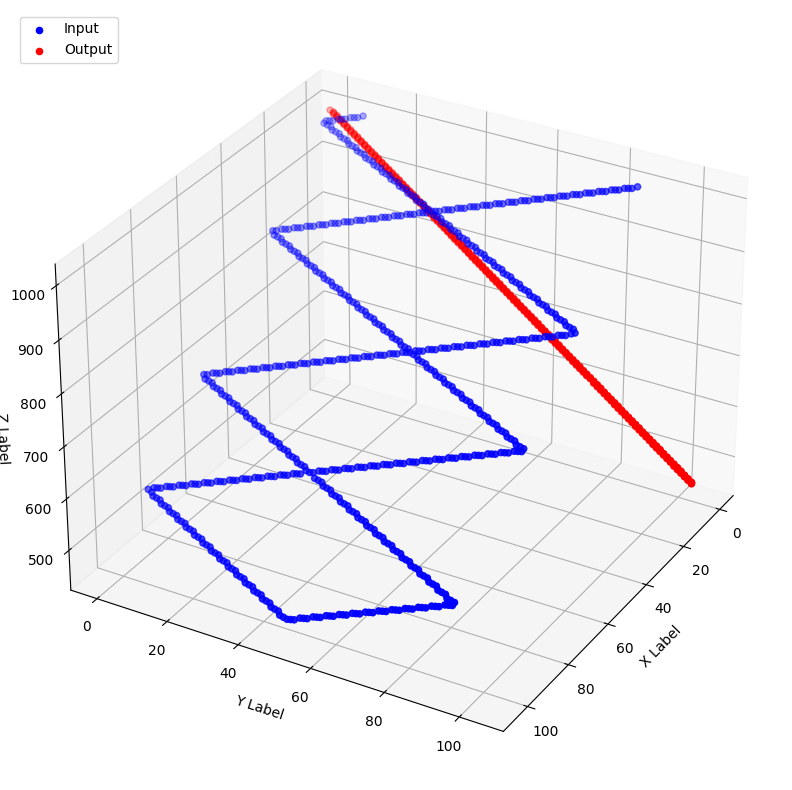

In [5]:
input_array = input_tensor.detach().cpu().numpy()
output_array = output_tensor.detach().cpu().numpy()
print(input_array.shape)
print(output_array.shape)

input_array = renormalise_time(input_array, timesteps)

input_3d = reconstruct_3D(input_array)
output_3d = reconstruct_3D(output_array)
print(input_3d.shape)
print(output_3d.shape)


# Plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input_3d[:, 0], input_3d[:, 1], input_3d[:, 2], c='b', marker='o', label='Input')
ax.scatter(output_3d[:,2], output_3d[:,0], output_3d[:, 1], c='r', marker='o', label='Output')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(azim=30, elev=30)
plt.legend(loc='upper left')
plt.show()

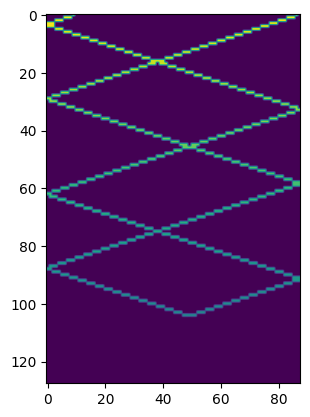

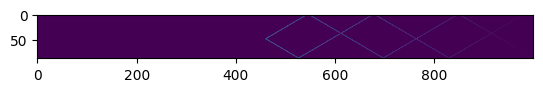

(128, 88)
(88, 1000)
(616, 3)
(614, 3)


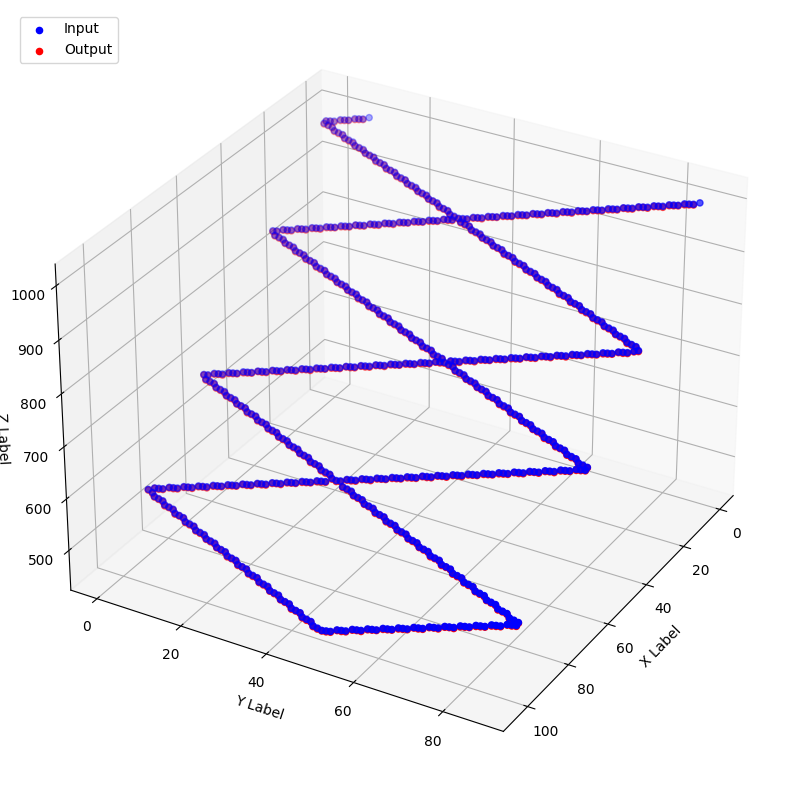

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#???? During processing we want the largest dimesnion to be the one that is virtual, wheras for loss calculation which is important yet trivial on compute we want the largest possible dimensional surface over which to calulate the loss. the smaller of the two dimensions is the one that should be made virtual

###idea""!"
### TRACK NUMBER OF POINTS LOST DUE TO OCLUSSION IN BOTH MEHGTODS (X AND Y) AN DUSE IT TO WEIGHT THEM IN LOSS???????

def reconstruct_3D(data, virtual_dim='t'):
    data_output = []
    for cdx, row in enumerate(data):
        for idx, num in enumerate(row):
            if num > 0:  
                if virtual_dim == 'x':
                    data_output.append([num,cdx,idx])

                if virtual_dim == 'y':
                    data_output.append([cdx,num,idx])

                if virtual_dim == 't':
                    data_output.append([cdx,idx,num])
    return np.array(data_output)

def renormalise_time(tensor, timesteps):
    tensor = tensor * timesteps
    return tensor

def holographic_transform(input_tensor, timesteps, virtual_dim='y', binary_values=True, debug=False):
    if not isinstance(input_tensor, torch.Tensor):
        raise ValueError("Input tensor should be a torch.Tensor")
    
    if len(input_tensor.shape) != 2:
        raise ValueError("Input tensor should be 2-dimensional")
    
    if timesteps <= 0:
        raise ValueError("Timesteps should be a positive integer")

    
    if virtual_dim not in ['x', 'y']:
        raise ValueError("Virtual dimension should be either 'x' or 'y'")
    
    if virtual_dim == 'x':
        input_tensor = input_tensor.T

    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    
    for i in range(input_tensor.shape[0]):
        non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
        for j in non_zero_indices:
            value = input_tensor[i,j]
            quantized_value = int(value * timesteps) - 1 

            if debug:
                print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
                print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

            if binary_values:
                output_tensor[i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
            else:  # BROKEN!!!!
                #if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                output_tensor[i, quantized_value] = j.item()


    return output_tensor

# Example usage
timesteps = 1000
virtual_dim = 'x'
binary_hologram = False
debug = False
input_file_path = r"N:\Yr 3 Project Datasets\PERF VALIDATION SETS\10K 100N 30S\Labels\126.npy .npy"

input_tensor = torch.from_numpy(np.load(input_file_path))
input_tensor = input_tensor / torch.max(input_tensor)
output_tensor = holographic_transform(input_tensor, timesteps, virtual_dim, binary_hologram, debug)    #(input_tensor.T, timesteps, binary_hologram)

# 2D Plotting
plt.imshow(input_tensor)
plt.show()

plt.imshow(output_tensor)
plt.show()












# Create 3D data
input_array = input_tensor.detach().cpu().numpy()
output_array = output_tensor.detach().cpu().numpy()
print(input_array.shape)
print(output_array.shape)

input_array = renormalise_time(input_array, timesteps)

input_3d = reconstruct_3D(input_array)
output_3d = reconstruct_3D(output_array, virtual_dim)
print(input_3d.shape)
print(output_3d.shape)


# 3D Plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(input_3d[:, 0], input_3d[:, 1], input_3d[:, 2], c='b', marker='o', label='Input')
ax.scatter(output_3d[:, 0], output_3d[:, 1], output_3d[:, 2], c='r', marker='o', label='Output')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(azim=30, elev=30)
plt.legend(loc='upper left')
plt.show()







In [ ]:

def holographic_transform(input_tensor, timesteps, virtual_dim='y', binary_values=True, debug=False):
    if not isinstance(input_tensor, torch.Tensor):
        raise ValueError("Input tensor should be a torch.Tensor")
    
    if len(input_tensor.shape) != 2:
        raise ValueError("Input tensor should be 2-dimensional")
    
    if timesteps <= 0:
        raise ValueError("Timesteps should be a positive integer")

    
    if virtual_dim not in ['x', 'y']:
        raise ValueError("Virtual dimension should be either 'x' or 'y'")
    
    if virtual_dim == 'x':
        input_tensor = input_tensor.T

    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    
    for i in range(input_tensor.shape[0]):
        non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
        for j in non_zero_indices:
            value = input_tensor[i,j]
            quantized_value = int(value * timesteps) - 1 

            if debug:
                print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
                print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

            if binary_values:
                output_tensor[i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
            else:  # BROKEN!!!!
                #if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                output_tensor[i, quantized_value] = j.item()


    return output_tensor

# Example usage
timesteps = 1000  # No point in exceeding time dimesnion in network?   btw does time dimesion do anything?? in norm?
virtual_dim = 'x'
binary_hologram = False
debug = False
input_file_path = r"N:\Yr 3 Project Datasets\PERF VALIDATION SETS\10K 100N 30S\Labels\126.npy .npy"

input_tensor = torch.from_numpy(np.load(input_file_path))
input_tensor = input_tensor / torch.max(input_tensor)
output_tensor = holographic_transform(input_tensor, timesteps, virtual_dim, binary_hologram, debug)    #(input_tensor.T, timesteps, binary_hologram)

# 2D Plotting
plt.imshow(input_tensor)
plt.show()

plt.imshow(output_tensor)
plt.show()


In [54]:

class ACBLoss3D(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, virtual_t_weighting=1, virtual_x_weighting=1, virtual_y_weighting=1, timesteps=1000):
        """
        Initializes the ACB-MSE-3D Holographic Loss Function class with weighting coefficients.

        Args:
        - zero_weighting: a scalar weighting coefficient for the MSE loss of zero pixels
        - nonzero_weighting: a scalar weighting coefficient for the MSE loss of non-zero pixels
        - virtual_t_weighting: a scalar weighting coefficient for the MSE loss of virtual t pixels
        - virtual_x_weighting: a scalar weighting coefficient for the MSE loss of virtual x pixels
        - virtual_y_weighting: a scalar weighting coefficient for the MSE loss of virtual y pixels
        """
        super().__init__()   
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting
        self.virtual_t_weighting = virtual_t_weighting
        self.virtual_x_weighting = virtual_x_weighting
        self.virtual_y_weighting = virtual_y_weighting
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.timesteps = timesteps
        if self.timesteps <= 0:
            raise ValueError("Timesteps to Holographic loss should be a positive integer")
        
    def holographic_transform(self, input_image, virtual_dim='y', binary_values=True, debug=False):

        input_batch = input_image.clone()
        output_batch = torch.zeros((input_batch.shape[0], input_batch.shape[1], input_batch.shape[2], self.timesteps), dtype=input_batch.dtype)

        for b in range(input_batch.shape[0]):

            input_tensor = input_batch[b, 0]
            
            if virtual_dim == 'x':
                input_tensor = input_tensor.T

            for i in range(input_tensor.shape[0]):
                non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
                for j in non_zero_indices:
                    value = input_tensor[i,j]
                    quantized_value = int(value * self.timesteps) - 1 

                    if debug:
                        print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
                        print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

                    if binary_values:
                        output_batch[b, 0, i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
                    else:  # BROKEN!!!!
                        #if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                        output_batch[b, 0, i, quantized_value] = j.item()

        return output_batch

    def ACB_MSE_Loss (self, reconstructed, target):
        reconstructed_image = reconstructed.clone()
        target_image = target.clone()
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss)

        return weighted_mse_loss

    def forward(self, reconstructed_image, target_image):

        vt_loss = self.ACB_MSE_Loss(reconstructed_image, target_image)
        reconstructed_hologram_vx = self.holographic_transform(reconstructed_image, virtual_dim='x')
        target_hologram_vx = self.holographic_transform(target_image, virtual_dim='x')
        vx_loss = self.ACB_MSE_Loss(reconstructed_hologram_vx, target_hologram_vx)

        reconstructed_hologram_vy = self.holographic_transform(reconstructed_image)
        target_hologram_vy = self.holographic_transform(target_image)
        vy_loss = self.ACB_MSE_Loss(reconstructed_hologram_vy, target_hologram_vy)

        return (vt_loss * self.virtual_t_weighting) + (vx_loss * self.virtual_x_weighting) + (vy_loss * self.virtual_y_weighting)
    

input_file_path = r"N:\Yr 3 Project Datasets\PERF VALIDATION SETS\10K 100N 30S\Labels\126.npy .npy"

input_t = torch.from_numpy(np.load(input_file_path))
input_t = input_t / torch.max(input_t)

loss_fn = ACBLoss3D()
loss = loss_fn(input_t.unsqueeze(0).unsqueeze(0), input_t.unsqueeze(0).unsqueeze(0))
print(loss)

tensor(0., dtype=torch.float64)


In [81]:
import torch
import torch.testing

# Define the original code
def original_code(input_tensor, timesteps):
    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    for i in range(input_tensor.shape[0]):
        non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
        for j in non_zero_indices:
            value = input_tensor[i, j]
            quantized_value = int(value * timesteps) - 1
            output_tensor[i, quantized_value] = j.item()
    return output_tensor

# Define the simplified code
def simplified_code_v1(input_tensor, timesteps):
    non_zero_indices_x, non_zero_indices_y = torch.nonzero(input_tensor, as_tuple=True)
    values = input_tensor[non_zero_indices_x, non_zero_indices_y]
    quantized_values = (values * timesteps).to(torch.int64) - 1                         # Values lie in range 0.0 - 1.0 

    output_tensor = torch.zeros((input_tensor.shape[0], timesteps), dtype=input_tensor.dtype)
    for quantized_value, non_zero_indice_x, non_zero_indice_y in zip(quantized_values, non_zero_indices_x, non_zero_indices_y):
        output_tensor[non_zero_indice_x, quantized_value] = non_zero_indice_y
    #output_tensor[non_zero_indices_x, quantized_values] = non_zero_indices_y
    return output_tensor

# Define the simplified code



def simplified_code_v2(input_tensor, timesteps):

    return None

# Example usage
batchsize = 2
channels = 3
x = 4
y = 4
timesteps = 10
input_tensor = torch.rand((batchsize, channels, x, y))
output_tensor = simplified_code_v2(input_tensor, timesteps)
print(output_tensor)





"""
# Define the simplified code
def simplified_code_v2(input_tensor, timesteps):
    non_zero_indices_x, non_zero_indices_y = torch.nonzero(input_tensor, as_tuple=True)
    values = input_tensor[non_zero_indices_x, non_zero_indices_y]
    quantized_values = (values * timesteps).to(torch.int64) - 1                         # Values lie in range 0.0 - 1.0 
    new_shape = list(input_tensor.shape)
    new_shape[-1] = timesteps
    output_tensor = torch.zeros(new_shape, dtype=input_tensor.dtype)
    for quantized_value, non_zero_indice_x, non_zero_indice_y in zip(quantized_values, non_zero_indices_x, non_zero_indices_y):
        output_tensor[non_zero_indice_x, quantized_value] = non_zero_indice_y
    return output_tensor

"""


# Generate random input data
input_tensor = torch.rand((10, 5))
timesteps = 5

# Compute outputs using both versions
output_original = original_code(input_tensor, timesteps)


output_simplified_v1 = simplified_code_v1(input_tensor, timesteps)

# Check if the outputs are the same
torch.testing.assert_close(output_original, output_simplified_v1)
print("V1 Test passed: The outputs are the same.")


output_simplified_v2 = simplified_code_v2(input_tensor, timesteps)

# Check if the outputs are the same
torch.testing.assert_close(output_original, output_simplified_v2)
print("V2 Test passed: The outputs are the same.")





None
V1 Test passed: The outputs are the same.


AssertionError: None mismatch: tensor([[0., 3., 2., 0., 4.],
        [0., 1., 0., 4., 2.],
        [0., 2., 3., 0., 4.],
        [0., 0., 0., 3., 4.],
        [0., 0., 0., 4., 1.],
        [2., 4., 0., 0., 3.],
        [2., 1., 0., 4., 3.],
        [1., 3., 2., 0., 4.],
        [0., 0., 2., 0., 4.],
        [2., 0., 3., 4., 0.]]) is not None

In [82]:
import timeit

# Time the execution of the original code
original_time = timeit.timeit(lambda: original_code(input_tensor, timesteps), number=1000)
print(f"Time taken by original code: {original_time:.6f} seconds")

# Time the execution of the simplified code
simplified_time = timeit.timeit(lambda: simplified_code_v1(input_tensor, timesteps), number=1000)
print(f"Time taken by simplified code: {simplified_time:.6f} seconds")

# Time the execution of the simplified code
simplified_time = timeit.timeit(lambda: simplified_code_v2(input_tensor, timesteps), number=1000)
print(f"Time taken by simplified code: {simplified_time:.6f} seconds")

Time taken by original code: 2.574386 seconds
Time taken by simplified code: 1.030458 seconds
Time taken by simplified code: 0.000169 seconds


In [66]:
import torch

# Example tensor with the original shape
original_tensor = torch.randn(2, 3, 4)  # Example shape: (2, 3, 4)

# User-specified new size for the last dimension
timesteps = 98

# Get the original shape except for the last dimension
new_shape = list(original_tensor.shape)
new_shape[-1] = timesteps

# Create a new tensor with zeros and the new shape
new_tensor = torch.zeros(new_shape)

print("Original Tensor:")
print(original_tensor.shape)
print("New Tensor:")
print(new_tensor.shape)


Original Tensor:
torch.Size([2, 3, 4])
New Tensor:
torch.Size([2, 3, 98])


In [ ]:

class ACBLoss3D(torch.nn.Module):
    def __init__(self, zero_weighting=1, nonzero_weighting=1, virtual_t_weighting=1, virtual_x_weighting=1, virtual_y_weighting=1, timesteps=1000):
        """
        Initializes the ACB-MSE-3D Holographic Loss Function class with weighting coefficients.

        Args:
        - zero_weighting: a scalar weighting coefficient for the MSE loss of zero pixels
        - nonzero_weighting: a scalar weighting coefficient for the MSE loss of non-zero pixels
        - virtual_t_weighting: a scalar weighting coefficient for the MSE loss of virtual t pixels
        - virtual_x_weighting: a scalar weighting coefficient for the MSE loss of virtual x pixels
        - virtual_y_weighting: a scalar weighting coefficient for the MSE loss of virtual y pixels
        """
        super().__init__()   
        self.zero_weighting = zero_weighting
        self.nonzero_weighting = nonzero_weighting
        self.virtual_t_weighting = virtual_t_weighting
        self.virtual_x_weighting = virtual_x_weighting
        self.virtual_y_weighting = virtual_y_weighting
        self.mse_loss = torch.nn.MSELoss(reduction='mean')
        self.timesteps = timesteps

        if self.timesteps <= 0:
            raise ValueError("Timesteps to Holographic loss should be a positive integer")
        
    def holographic_transform(self, input_image, virtual_dim='y', binary_values=True, debug=False):

        input_batch = input_image.clone()
        output_batch = torch.zeros((input_batch.shape[0], input_batch.shape[1], input_batch.shape[2], self.timesteps), dtype=input_batch.dtype)

        for b in range(input_batch.shape[0]):

            input_tensor = input_batch[b, 0]
            
            if virtual_dim == 'x':
                input_tensor = input_tensor.T

            for i in range(input_tensor.shape[0]):
                non_zero_indices = torch.nonzero(input_tensor[i]).squeeze(dim=1)
                for j in non_zero_indices:
                    value = input_tensor[i,j]
                    quantized_value = int(value * self.timesteps) - 1 

                    if debug:
                        print(f"\nInput Coordinate: (y x t), ({i}, {j.item()}, {quantized_value})")
                        print(f"Transforms to: (y t x), ({i}, {quantized_value}, {j.item()})\n")

                    if binary_values:
                        output_batch[b, 0, i, quantized_value] = 1.0 #value set to fixed mask rather than embedded x coordinate, will test both ideas
                    else:  # BROKEN!!!!
                        #if value > output_tensor[i, quantized_value]:   # Fix x occlusion mapping, this check is wrong at the moment, it should check if the ?
                        output_batch[b, 0, i, quantized_value] = j.item()

        return output_batch

    def ACB_MSE_Loss (self, reconstructed, target):
        reconstructed_image = reconstructed.clone()
        target_image = target.clone()
        """
        Calculates the weighted mean squared error (MSE) loss between target_image and reconstructed_image.
        The loss for zero pixels in the target_image is weighted by zero_weighting, and the loss for non-zero
        pixels is weighted by nonzero_weighting.

        Args:
        - target_image: a tensor of shape (B, C, H, W) containing the target image
        - reconstructed_image: a tensor of shape (B, C, H, W) containing the reconstructed image

        Returns:
        - weighted_mse_loss: a scalar tensor containing the weighted MSE loss
        """
        zero_mask = (target_image == 0)
        nonzero_mask = ~zero_mask

        values_zero = target_image[zero_mask]
        values_nonzero = target_image[nonzero_mask]

        corresponding_values_zero = reconstructed_image[zero_mask]
        corresponding_values_nonzero = reconstructed_image[nonzero_mask]

        zero_loss = self.mse_loss(corresponding_values_zero, values_zero)
        nonzero_loss = self.mse_loss(corresponding_values_nonzero, values_nonzero)

        if torch.isnan(zero_loss):
            zero_loss = 0
        if torch.isnan(nonzero_loss):
            nonzero_loss = 0

        weighted_mse_loss = (self.zero_weighting * zero_loss) + (self.nonzero_weighting * nonzero_loss)

        return weighted_mse_loss

    def forward(self, reconstructed_image, target_image):

        vt_loss = self.ACB_MSE_Loss(reconstructed_image, target_image)
        reconstructed_hologram_vx = self.holographic_transform(reconstructed_image, virtual_dim='x')
        target_hologram_vx = self.holographic_transform(target_image, virtual_dim='x')
        vx_loss = self.ACB_MSE_Loss(reconstructed_hologram_vx, target_hologram_vx)

        reconstructed_hologram_vy = self.holographic_transform(reconstructed_image)
        target_hologram_vy = self.holographic_transform(target_image)
        vy_loss = self.ACB_MSE_Loss(reconstructed_hologram_vy, target_hologram_vy)

        return (vt_loss * self.virtual_t_weighting) + (vx_loss * self.virtual_x_weighting) + (vy_loss * self.virtual_y_weighting)
    



In [92]:
def holographic_transform(self, input_image, virtual_dim='y', binary_values=True, debug=False):

    input_batch = input_image.clone()
    output_batch = torch.zeros((input_batch.shape[0], input_batch.shape[1], input_batch.shape[2], self.timesteps), dtype=input_batch.dtype)

    for b in range(input_batch.shape[0]):

        input_tensor = input_batch[b, 0]
        
        if virtual_dim == 'x':
            input_tensor = input_tensor.T

        non_zero_indices_x, non_zero_indices_y = torch.nonzero(input_tensor, as_tuple=True)
        values = input_tensor[non_zero_indices_x, non_zero_indices_y]
        quantized_values = (values * self.timesteps).to(torch.int64) - 1                         # Values lie in range 0.0 - 1.0 

        for quantized_value, non_zero_indice_x, non_zero_indice_y in zip(quantized_values, non_zero_indices_x, non_zero_indices_y):
            output_batch[b, 0, non_zero_indice_x, quantized_value] = non_zero_indice_y

    return output_batch

In [93]:
def holographic_transform2(self, input_image, virtual_dim='y', binary_values=True, debug=False):

    input_batch = input_image.clone()
    output_batch = torch.zeros((input_batch.shape[0], input_batch.shape[1], input_batch.shape[2], self.timesteps), dtype=input_batch.dtype)

    for b in range(input_batch.shape[0]):

        input_tensor = input_batch[b, 0]
        
        if virtual_dim == 'x':
            input_tensor = input_tensor.T

        non_zero_indices_x, non_zero_indices_y = torch.nonzero(input_tensor, as_tuple=True)
        values = input_tensor[non_zero_indices_x, non_zero_indices_y]
        quantized_values = (values * self.timesteps).to(torch.int64) - 1                         # Values lie in range 0.0 - 1.0 

        for quantized_value, non_zero_indice_x, non_zero_indice_y in zip(quantized_values, non_zero_indices_x, non_zero_indices_y):
            output_batch[b, 0, non_zero_indice_x, quantized_value] = non_zero_indice_y

    return output_batch

In [94]:
# Generate random input data
input_tensor = torch.rand((10, 3, 10, 5))
timesteps = 5

# Compute outputs using both versions
output_original = holographic_transform(input_tensor, timesteps)


output_simplified_v1 = holographic_transform2(input_tensor, timesteps)

# Check if the outputs are the same
torch.testing.assert_close(output_original, output_simplified_v1)
print("V1 Test passed: The outputs are the same.")


AttributeError: 'int' object has no attribute 'clone'